In [1]:
%load_ext autoreload
%autoreload 2
%aimport -torch

In [2]:
import torch
try:  
    # Attempt to disable torch.compile for faster iteration, but if it fails 
    # (probably due to older pytorch version) we just proceed anyway
    torch.compiler.set_stance("force_eager")
except:
    pass

from omegaconf import OmegaConf
from flowmo import train_utils
import mediapy, einops

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/svl/u/kevin02/miniconda3/envs/FlowMo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


""

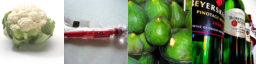

In [3]:
# Set up the data.
config = OmegaConf.load('flowmo/configs/base.yaml')
config.data.batch_size = 4
config.data.num_workers = 0
config.data.image_size = 64

torch.manual_seed(3)
val_dataloader = train_utils.load_dataset(config, 'val', shuffle_val=True)
batch = next(train_utils.wrap_dataloader([next(iter(val_dataloader))]))

images = batch['image']
mediapy.show_image(einops.rearrange(images.cpu()/2+.5, "b c h w -> h (b w) c"), vmin=0, vmax=1)

In [10]:
# Choose your model
model_name = "flowmo_hi_larp_qwen3_0.6b_64x64_pretrain"

# The low BPP model has 18 bits per token, the high bitrate model has 56 bits per token.
zoo = {
    "flowmo_hi_larp_qwen3_0.6b_rand_64x64_pretrain": {"prior.model_name": "Qwen3-0.6B", "context_dim": 56, "codebook_size_for_entropy": 14, "patch_size": 4, "mup_width": 4, "code_length": 64, "quantization_type": "larp", "ckpt_path": "results/flowmo_hi_larp_qwen3_0.6b_rand_64x64_pretrain/checkpoints/00100000.pth"},
    "flowmo_hi_larp_qwen3_0.6b_64x64_pretrain": {"prior.model_name": "Qwen3-0.6B", "context_dim": 56, "codebook_size_for_entropy": 14, "patch_size": 4, "mup_width": 4, "code_length": 64, "quantization_type": "larp", "ckpt_path": "results/flowmo_hi_larp_qwen3_0.6b_64x64_pretrain/checkpoints/00060000.pth"},
    "flowmo_hi_larp_no_prior_loss_64x64_pretrain": {"prior.model_name": "gptc-S", "context_dim": 56, "codebook_size_for_entropy": 14, "patch_size": 4, "mup_width": 4, "code_length": 64, "quantization_type": "larp", "ckpt_path": "results/flowmo_hi_larp_no_prior_loss_64x64_pretrain/checkpoints/00080000.pth"},
    "flowmo_hi_larp_64x64_pretrain": {"context_dim": 56, "codebook_size_for_entropy": 14, "patch_size": 4, "mup_width": 4, "code_length": 64, "quantization_type": "larp", "ckpt_path": "results/flowmo_hi_larp_64x64_pretrain/checkpoints/00020000.pth"},
    "flowmo_hi_lfq_64x64_pretrain": {"context_dim": 56, "patch_size": 4, "mup_width": 4, "code_length": 64, "ckpt_path": "results/flowmo_hi_lfq_64x64_pretrain/checkpoints/00080000.pth"},
    "flowmo_lo": {"context_dim": 18, "ckpt_path": "flowmo_lo.pth"},
    "flowmo_hi": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth"},
    "flowmo_lfq_qwen_hi_targets_sg_pretrain": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth", "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_qwen_hi_targets_sg_pretrain/checkpoints/00050000.pth"},
    "flowmo_lfq_qwen_hi_targets_sg_50xlr_bce_0.004_pretrain": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth", "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_qwen_hi_targets_sg_50xlr_bce_0.004_pretrain/checkpoints/00120000.pth"},
    "flowmo_lfq_qwen_hi_targets_sg_50xlr_bce_0.006_pretrain": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth", "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_qwen_hi_targets_sg_50xlr_bce_0.006_pretrain/checkpoints/00200000.pth"},
    "flowmo_lfq_qwen_hi_targets_sg_50xlr_bce_0.01_pretrain": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth", "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_qwen_hi_targets_sg_50xlr_bce_0.01_pretrain/checkpoints/00200000.pth"},
    "flowmo_lfq_qwen_hi_all_sg_pretrain": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth", "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_qwen_hi_all_sg_pretrain/checkpoints/00050000.pth"},
    "flowmo_lfq_qwen_hi_ft_pretrain": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth", "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_qwen_hi_ft_pretrain/checkpoints/00050000.pth"},
    "flowmo_hi_45000": {"context_dim": 56, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_pretrain/checkpoints/00045000.pth"},
    "flowmo_hi_50000": {"context_dim": 56, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_pretrain/checkpoints/00050000.pth"},
    "flowmo_hi_kl": {"context_dim": 768, "quantization_type": "kl", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_kl_pretrain/checkpoints/00015000.pth"},
    "flowmo_hi_noop": {"context_dim": 768, "quantization_type": "noop", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_noop_pretrain/checkpoints/00050000.pth"},
    "flowmo_hi_qwen2.5-coder-0.5b_span_0.3": {"context_dim": 896, "quantization_type": "qwen2.5-coder-0.5b_span_0.3", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_qwen2.5-coder-0.5b_pretrain/checkpoints/00095000.pth"},
    "flowmo_hi_qwen2.5-coder-0.5b_span_0.6": {"context_dim": 896, "quantization_type": "qwen2.5-coder-0.5b_span_0.6", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_qwen2.5-coder-0.5b_span_0.6_pretrain/checkpoints/00095000.pth"},
    "flowmo_hi_qwen2.5-coder-0.5b_span_0.9": {"context_dim": 896, "quantization_type": "qwen2.5-coder-0.5b_span_0.9", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_qwen2.5-coder-0.5b_span_0.9_pretrain/checkpoints/00095000.pth"},
    "flowmo_lfq_256_4096": {"context_dim": 12, "code_length": 256, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_256_4096_pretrain/checkpoints/00090000.pth"},
    "flowmo_lfq_256_16384": {"context_dim": 12, "code_length": 256, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_256_16384_pretrain/checkpoints/00090000.pth"},
    "flowmo_lfq_512_4096": {"context_dim": 12, "code_length": 256, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_512_4096_pretrain/checkpoints/00300000.pth"},
    "flowmo_lfq_repa_encoder_256_4096": {"context_dim": 12, "code_length": 256, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_repa_encoder_256_4096_pretrain/checkpoints/00010000.pth"},
    "flowmo_lfq_repa_encoder_512_4096": {"context_dim": 12, "code_length": 512, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_repa_encoder_512_4096_pretrain/checkpoints/00100000.pth"},
    "flowmo_lfq_repa_encoder_512_16384": {"context_dim": 14, "code_length": 512, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lfq_repa_encoder_512_16384_pretrain/checkpoints/00100000.pth"},
    "flowmo_lqae_pretrain_code_length_512_batch_size_16": {"context_dim": 768, "code_length": 512, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_lqae_pretrain_code_length_512_batch_size_16/checkpoints/00025000.pth"},
}
if 'ckpt_path' in zoo[model_name]:
    state_dict = torch.load(zoo[model_name]['ckpt_path'], map_location='cuda')
config.model.context_dim = zoo[model_name]['context_dim']
if 'patch_size' in zoo[model_name]:
    config.model.patch_size = zoo[model_name]['patch_size']
if 'mup_width' in zoo[model_name]:
    config.model.mup_width = zoo[model_name]['mup_width']
if 'code_length' in zoo[model_name]:
    config.model.code_length = zoo[model_name]['code_length']
if 'quantization_type' in zoo[model_name]:
    config.model.quantization_type = zoo[model_name]['quantization_type']
if 'prior.model_name' in zoo[model_name]:
    config.prior.model_name = zoo[model_name]['prior.model_name']
if 'codebook_size_for_entropy' in zoo[model_name]:
    config.model.codebook_size_for_entropy = zoo[model_name]['codebook_size_for_entropy']
else:
    config.model.codebook_size_for_entropy = 1  # don't need this at test time.

model = train_utils.build_model(config)
if 'ckpt_path' in zoo[model_name]:
    # Filter out keys starting with 'qwen_model'
    filtered_state_dict = {k: v for k, v in state_dict['model_ema_state_dict'].items() if not k.startswith('qwen_model')}
    # Load the filtered state dict, ignoring missing keys (like the qwen_model ones)
    missing_keys, unexpected_keys = model.load_state_dict(filtered_state_dict, strict=False)
    print(f'Missing keys: {missing_keys}')
    print(f'Unexpected keys: {unexpected_keys}')

/tmp/user/24098/ipykernel_366286/305769841.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(zoo[model_name]['ckpt_path'], map_location='cuda')


Mup enabled!
Missing keys: []
Unexpected keys: []


In [5]:
# from transformers import AutoModelForCausalLM
# import torch.nn.functional as F

# # Load the original Qwen model
# original_qwen = AutoModelForCausalLM.from_pretrained(
#     'Qwen/Qwen3-0.6B-Base',
#     torch_dtype="auto",
# ).to('cuda:0').model

# # Function to compute cosine similarity between two tensors
# def cosine_similarity(tensor1, tensor2):
#     # Normalize the tensors
#     tensor1_norm = F.normalize(tensor1.flatten(), p=2, dim=0)
#     tensor2_norm = F.normalize(tensor2.flatten(), p=2, dim=0)
#     # Compute cosine similarity
#     return torch.dot(tensor1_norm, tensor2_norm).item()

# # print(list(original_qwen.named_parameters()))
# # print(list(model.quantizer.prior_model.model.named_parameters()))

# # Compare weights between the two models
# similarities = {}
# for (name1, param1), (name2, param2) in zip(model.quantizer.prior_model.model.named_parameters(), original_qwen.named_parameters()):
#     if name1 == name2 and param1.shape == param2.shape:
#         sim = cosine_similarity(param1, param2)
#         similarities[name1] = sim
#         print(f"{name1}: {sim:.4f}")

# # Compute average similarity
# avg_similarity = sum(similarities.values()) / len(similarities)
# print(f"\nAverage similarity: {avg_similarity:.4f}")


In [6]:
# model.config.eval.sampling.sample_steps = 100
# config.eval.sampling.cfg_interval = None

""

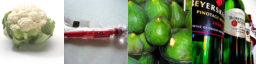

""

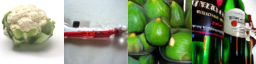

In [16]:
# Reconstruct the images. If you want to use your own images, FlowMo accepts
# images in [-1, 1] in bchw format.

model.eval()
with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
    images_rec, _ = model.reconstruct(images)

# Show the original and reconstructed.
mediapy.show_image(einops.rearrange(images.cpu().numpy()/2+.5, "b c h w -> h (b w) c"))
mediapy.show_image(einops.rearrange(images_rec.cpu().numpy()/2+.5, "b c h w -> h (b w) c"))